In [4]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Dense,Dropout,LSTM,Embedding,BatchNormalization,Activation
from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import matplotlib.pyplot as py
import seaborn as sns
from tqdm import tqdm
from keras.models import load_model
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop
import pandas as pd
import re
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
lemmatizer = WordNetLemmatizer()

In [2]:
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Venky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Venky\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:

p2=pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)


In [5]:
p2.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
p2[p2['is_sarcastic']==0]
p2.iloc[26,0]

'https://www.huffingtonpost.com/entry/obama-veterans-day_us_564372e9e4b08cda3486f09b'

In [7]:
p2.drop('article_link',inplace=True,axis=1)

In [8]:
p2['headline']=p2['headline'].apply(str)

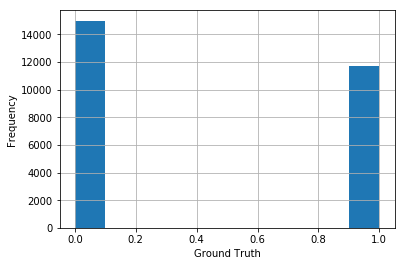

In [9]:
p2['is_sarcastic'].hist()
py.xlabel('Ground Truth')
py.ylabel('Frequency')
py.show()

In [10]:
X_train,x_test,Y_train,y_test=train_test_split(pd.DataFrame(p2['headline']),pd.DataFrame(p2['is_sarcastic']),test_size=0.2)

In [11]:
def clean_sentences(df):
    clean = []
    
    for sent in tqdm(df['headline']):

        #remove non-alphabetic characters
        cleaned_text = re.sub("[^a-zA-Z]"," ", sent)
    
        #tokenize the sentences
        words = word_tokenize(cleaned_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        clean.append(lemma_words)

    return(clean)
train=X_train
test=x_test

#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

print(len(train_sentences))
print(len(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████| 5342/5342 [00:01<00:00, 3662.59it/s]


21367
5342


In [12]:
target=Y_train.is_sarcastic.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [13]:
x_train,x_val,y_train,y_val=train_test_split(train_sentences,Y_train,test_size=0.2)

In [14]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(test_sentences)
x_train = sequence.pad_sequences(x_train, maxlen=len_max)
x_val = sequence.pad_sequences(x_val, maxlen=len_max)
x_test = sequence.pad_sequences(x_test, maxlen=len_max)



100%|████████████████████████████████████████████████████████████████████████| 17093/17093 [00:00<00:00, 510948.57it/s]


In [48]:
len_max

38

# Logistic Regression

In [16]:
rf=LogisticRegression()

In [18]:
rf.fit(x_train,y_train)

C:\Users\Venky\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Venky\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Venky\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred=rf.predict(x_train)
y_pred1=rf.predict(x_val)
y_pred2=rf.predict(x_test)

In [20]:
print('--------------- Logistic Regression --------------\n')
print('Training accuracy = {s2} \nValidation accuracy= {s1} \nTesting Accuracy= {s3}'.format(s1=accuracy_score(y_val,y_pred1),s2=accuracy_score(y_train,y_pred),s3=accuracy_score(y_test,y_pred2)))

--------------- Logistic Regression --------------

Training accuracy = 0.5920552272860236 
Validation accuracy= 0.5732335049134301 
Testing Accuracy= 0.5780606514414077


# Naive Bayes using MultinomialNB

In [110]:
rf=MultinomialNB()

In [111]:
rf.fit(x_train,y_train)

C:\Users\Venky\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [112]:
y_pred=rf.predict(x_train)
y_pred1=rf.predict(x_val)
y_pred2=rf.predict(x_test)

In [114]:
print('--------------- Naive Bayes --------------\n')
print('Training accuracy = {s2} \nValidation accuracy= {s1} \nTesting Accuracy= {s3}'.format(s1=accuracy_score(y_val,y_pred1),s2=accuracy_score(y_train,y_pred),s3=accuracy_score(y_test,y_pred2)))

--------------- Naive Bayes --------------

Training accuracy = 0.5294565026619084 
Validation accuracy= 0.5271408516612073 
Testing Accuracy= 0.5183451890677648


In [115]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.59      0.48      0.53      3012
           1       0.46      0.57      0.51      2330

   micro avg       0.52      0.52      0.52      5342
   macro avg       0.52      0.52      0.52      5342
weighted avg       0.53      0.52      0.52      5342



In [116]:
print(confusion_matrix(y_test,y_pred2))

[[1432 1580]
 [ 993 1337]]


# Random Forest Classifier

In [25]:
rf=RandomForestClassifier()

In [26]:
rf.fit(x_train,y_train)

C:\Users\Venky\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Venky\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
y_pred=rf.predict(x_train)
y_pred1=rf.predict(x_val)
y_pred2=rf.predict(x_test)

In [28]:
print('--------------- Random Forest Classifier --------------\n')
print('Training accuracy = {s2} \nValidation accuracy= {s1} \nTesting Accuracy= {s3}'.format(s1=accuracy_score(y_val,y_pred1),s2=accuracy_score(y_train,y_pred),s3=accuracy_score(y_test,y_pred2)))

--------------- Random Forest Classifier --------------

Training accuracy = 0.9850816123559352 
Validation accuracy= 0.6228357510528779 
Testing Accuracy= 0.6205540995881692


# Support Vector Machine

In [33]:
rf=SVC(C=1e+8)

In [34]:
rf.fit(x_train,y_train)

C:\Users\Venky\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Venky\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=100000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [35]:
y_pred=rf.predict(x_train)
y_pred1=rf.predict(x_val)
y_pred2=rf.predict(x_test)

In [39]:
print('--------------- SVM --------------\n')
print('Training accuracy = {s2} \nValidation accuracy= {s1} \nTesting Accuracy= {s3}'.format(s1=accuracy_score(y_val,y_pred1),s2=accuracy_score(y_train,y_pred),s3=accuracy_score(y_test,y_pred2)))

--------------- SVM --------------

Training accuracy = 1.0 
Validation accuracy= 0.5615348619560131 
Testing Accuracy= 0.5627105952826656


# LSTM

In [15]:
x_train,x_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2)  #y_target for LSTM,Y_train for traditional models

In [16]:
unique_words = set()
len_max = 0
for sent in tqdm(x_train):
    unique_words.update(sent)
    if(len_max<len(sent)):
        len_max = len(sent)
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(test_sentences)
x_train = sequence.pad_sequences(x_train, maxlen=len_max)
x_val = sequence.pad_sequences(x_val, maxlen=len_max)
x_test = sequence.pad_sequences(x_test, maxlen=len_max)

100%|████████████████████████████████████████████████████████████████████████| 17093/17093 [00:00<00:00, 489290.14it/s]


In [17]:
ml=Sequential()
ml.add(Embedding(len(list(unique_words)),300,input_length=len_max))
ml.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
ml.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
ml.add(Dense(50,activation='relu'))
ml.add(Dropout(0.5))
ml.add(Dense(50))
ml.add(BatchNormalization())
ml.add(Activation('relu'))
ml.add(Dense(50,activation='relu'))
ml.add(Dense(num_classes,activation='softmax'))
ml.compile(optimizer=RMSprop(lr=0.01),metrics=['accuracy'],loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
ml.fit(x_train,y_train,validation_data=[x_val,y_val],epochs=2,batch_size=250)

Instructions for updating:
Use tf.cast instead.
Train on 17093 samples, validate on 4274 samples
Epoch 1/2
17093/17093 [==============================] - ETA: 8:08 - loss: 0.7358 - acc: 0.436 - ETA: 4:10 - loss: 1.0211 - acc: 0.478 - ETA: 2:50 - loss: 0.9835 - acc: 0.482 - ETA: 2:10 - loss: 0.9213 - acc: 0.492 - ETA: 1:46 - loss: 0.8819 - acc: 0.494 - ETA: 1:29 - loss: 0.8496 - acc: 0.506 - ETA: 1:18 - loss: 0.8315 - acc: 0.508 - ETA: 1:09 - loss: 0.8152 - acc: 0.512 - ETA: 1:02 - loss: 0.8013 - acc: 0.515 - ETA: 57s - loss: 0.7879 - acc: 0.525 - ETA: 52s - loss: 0.7811 - acc: 0.52 - ETA: 48s - loss: 0.7741 - acc: 0.52 - ETA: 45s - loss: 0.7669 - acc: 0.53 - ETA: 42s - loss: 0.7621 - acc: 0.53 - ETA: 39s - loss: 0.7569 - acc: 0.53 - ETA: 37s - loss: 0.7539 - acc: 0.53 - ETA: 35s - loss: 0.7493 - acc: 0.53 - ETA: 33s - loss: 0.7470 - acc: 0.53 - ETA: 32s - loss: 0.7447 - acc: 0.53 - ETA: 30s - loss: 0.7427 - acc: 0.53 - ETA: 29s - loss: 0.7405 - acc: 0.53 - ETA: 27s - loss: 0.7385 - acc

In [19]:
y_pred=ml.predict_classes(x_val)
y_pred1=ml.predict_classes(x_train)
y_pred2=ml.predict_classes(x_test)
y_val1=np.argmax(y_val,axis=1)
y_train1=np.argmax(y_train,axis=1)
str1='Training accuracy = {s2} \nValidation accuracy= {s1} \nTesting Accuracy= {s3}'.format(s1=accuracy_score(y_val1,y_pred),s2=accuracy_score(y_train1,y_pred1),s3=accuracy_score(y_test,y_pred2))

In [20]:
print('--------------- LSTM --------------\n')
print(str1)

--------------- LSTM --------------

Training accuracy = 0.932486982975487 
Validation accuracy= 0.8528310715956949 
Testing Accuracy= 0.8464994384125796


In [21]:
ml.save('model.h5')

In [22]:
m1=load_model('model.h5')

In [57]:
y_pred=m1.predict_classes(x_val)
y_pred1=m1.predict_classes(x_train)
y_pred2=m1.predict_classes(x_test)
y_val1=np.argmax(y_val,axis=1)
y_train1=np.argmax(y_train,axis=1)
str1='Training accuracy = {s2} \nValidation accuracy= {s1} \nTesting Accuracy= {s3}'.format(s1=accuracy_score(y_val1,y_pred),s2=accuracy_score(y_train1,y_pred1),s3=accuracy_score(y_test,y_pred2))

In [23]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3025
           1       0.81      0.84      0.83      2317

   micro avg       0.85      0.85      0.85      5342
   macro avg       0.84      0.85      0.84      5342
weighted avg       0.85      0.85      0.85      5342



In [24]:
print(confusion_matrix(y_test,y_pred2))

[[2578  447]
 [ 373 1944]]


In [25]:
def process(sent):
    sent1=clean_sentences(sent)
    senti=tokenizer.texts_to_sequences(sent1)
    senti=sequence.pad_sequences(senti,maxlen=len_max)
    return senti
def predict_value(senten):
    di={'headline':senten}
    pd1=pd.DataFrame(di,index=[0])
    #print(pd1.head())
    s=ml.predict_proba(process(pd1))
    print('The model is {s1}% confident that the sentence is sarcastic'.format(s1=(s[0][1]*100).round(decimals=2)))

In [26]:
s=predict_value('Cancer cures smoking')


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2528.21it/s]


The model is 97.42% confident that the sentence is sarcastic
